# Run TJPCOV with LSST Specs

TODO:
- Get the n(z) and binning of LSST from CCLX notebooks
- Get the mask of LSST
- Make the initiaiton of the sacc file
- Get the Gaussian and Namaster covariance 

Then to include CMB lensing
- Maks of CMB maps (Planck, SO and S4)
- Compute the Gaussian and the Namaster covariances

But for CMB lensing we need to include the CMB K reconstruction noise whihc depends on the experiment considered. For now I had a random constant to have teh cmbk noise in TJPCov

In [1]:
import sacc
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as pl
import healpy as hp
import pymaster as nmt

In [2]:
ccl.__version__

'3.0.0'

In [3]:
# Set this directory according to where it is on your computer
cclx_dir = '/Users/louis/code/CCLX'

In [4]:
# mask_lsst = hp.read_map('mask_lsst/map_for_paul.fits')

In [5]:
# Import the binning recipes of LSST DESC 

import sys, os
sys.path.append(os.path.join(cclx_dir))

import srd_redshift_distributions as srd
import binning

In [6]:
# Define the redshift interval and forecast years
redshift_range = np.linspace(0.01, 3.5, 300)
forecast_years = ["1", "10"] 

# Create a dictionary to store the redshift distributions
# for each forecast year and galaxy sample
redshift_distribution = {
    "sources": {},
    "lenses": {}
}

normalised = False
for year in forecast_years:
    source_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                               galaxy_sample="source_sample",
                                               forecast_year=year)
    lens_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                             galaxy_sample="lens_sample",
                                             forecast_year=year)

    redshift_distribution["sources"][year] = source_dist.get_redshift_distribution(normalised=normalised,
                                                                                   save_file=False)
    redshift_distribution["lenses"][year] = lens_dist.get_redshift_distribution(normalised=normalised,
                                                                                save_file=False)

In [7]:
# Define a dictionary to store the bins
bins = {
    "sources": {},
    "lenses": {}
}
normalised = False
# Perform the binning procedure
for year in forecast_years:
    bins["sources"][year] = binning.Binning(redshift_range, 
                                            redshift_distribution["sources"][year],
                                            year).source_bins(normalised=normalised,
                                                              save_file=False)
    bins["lenses"][year] = binning.Binning(redshift_range, 
                                           redshift_distribution["lenses"][year],
                                           year).lens_bins(normalised=normalised,
                                                           save_file=False)


Text(0.5, 0, 'z')

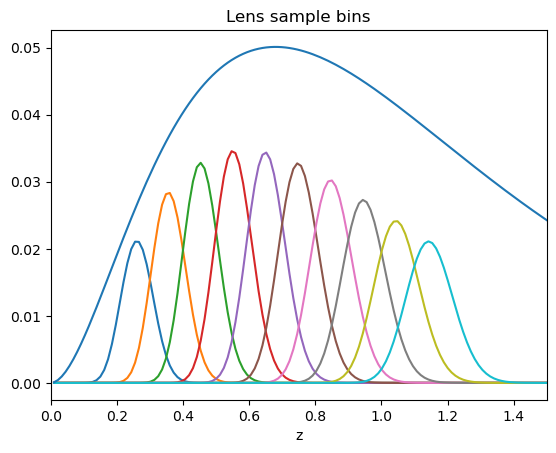

In [8]:
# plots 
year = '10' 

for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
    pl.plot(redshift_range,
            -data, 
            label=f"Bin {key+1}",)
pl.xlim(0, 1.5)

pl.plot(redshift_range, redshift_distribution["lenses"][year] )

pl.title('Lens sample bins')
pl.xlabel('z')

Text(0.5, 0, 'z')

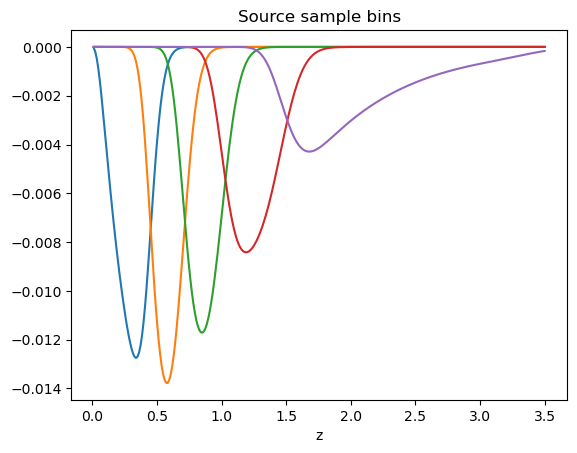

In [9]:
for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):
    pl.plot(redshift_range,
            data, 
            label=f"Bin {key+1}",)
# pl.xlim(0, 1.5)


pl.title('Source sample bins')
pl.xlabel('z')

## Generate the data
We will first use CCL to generate some data. This will include all the auto- and cross-correlations between a redshift bin with galaxy clustering and cosmic shear, one CMB lensing map and I/Q/U maps in a given frequency channel.

In [10]:
bins["sources"][year].keys()

dict_keys([0, 1, 2, 3, 4])

In [11]:
# bpw_edges = np.array(
#         [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96]
#     )

n_ell = 20
bpw_edges = np.geomspace(20, 3000, n_ell+1)
ells = np.array((bpw_edges[1:] + bpw_edges[:-1])/2, dtype='int')
d_ell = np.diff(bpw_edges)

# density, shear_E, shear_B, I, Q, U, kappa
# n_maps = 3 + 3 + 1
# density, shear_E, shear_B, kappa
# n_maps = 3 + 1

# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.72, n_s=0.96, A_s=2.1e-9)

### LSS power spectra
First we create the galaxy clustering (GC), weak lensing (WL) and CMB lensing tracers with CCL for which we will compute power spectra

In [12]:
import yaml

In [13]:
with open(os.path.join(cclx_dir, "parameters/lsst_desc_parameters.yaml"), "r") as f:
    lsst_parameters = yaml.load(f, Loader=yaml.FullLoader)

In [14]:
# CCL tracers

forecast_year = '10' 

galaxy_bias_prefactor = lsst_parameters['lens_sample'][forecast_year]['galaxy_bias_prefactor']
# bz = 1 + redshift_range 
# Also we negelt IA for now 
bias_z = galaxy_bias_prefactor / cosmo.growth_factor(1/(1+redshift_range))

gc = {}
sh = {}

for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
    gc[bin_idx] = ccl.NumberCountsTracer(cosmo, dndz=(redshift_range, data), bias=(redshift_range, bias_z), has_rsd=True)
    sh[bin_idx] = ccl.WeakLensingTracer(cosmo, dndz=(redshift_range, data), ia_bias=None)

ck = ccl.CMBLensingTracer(cosmo, z_source=1100.)




In [15]:
np.trapz(redshift_distribution["sources"][year], redshift_range)

0.01993151949449299

In [16]:
# Get gal density per bin

n_bar_lens = lsst_parameters['lens_sample'][year]['n_bar']
n_bar_source = lsst_parameters['source_sample'][year]['n_bar']

nbar_gc = {}
nbar_sh = {}

for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):    
    nbar_gc[bin_idx] = -np.trapz(data, redshift_range) 
norm_tot = np.sum(np.fromiter((nbar_gc[k] for k in nbar_gc.keys()), float))
for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
    nbar_gc[bin_idx] *= n_bar_lens / norm_tot
    
for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):    
    nbar_sh[bin_idx] = -np.trapz(data, redshift_range) 

norm_tot = np.sum(np.fromiter((nbar_sh[k] for k in nbar_sh.keys()), float))
for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):
    nbar_sh[bin_idx] *= n_bar_source / norm_tot
 

In [17]:
# Noise power spectra
nl_gc = {}
nl_sh = {}
sigma_e = 0.26

for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
    nl_gc[bin_idx] = np.ones(n_ell) / (nbar_gc[bin_idx] * (60 * 180 / np.pi)**2)

for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):       
    nl_sh[bin_idx] = np.ones(n_ell) * sigma_e**2 / (nbar_sh[bin_idx] * (60 * 180 / np.pi)**2)


# Power spectra

In [18]:
cls = {}

for bin_idx in bins["lenses"][year]:
#     ells_bin = np.array((bpw_edges[1:] + bpw_edges[:-1])/2, dtype='int')
    cls_gc[f'G{bin_idx}-G{bin_idx}'] = ccl.angular_cl(cosmo, gc[bin_idx], gc[bin_idx], ells)
    p = pl.plot(ells, cls_gc[f'G{bin_idx}-G{bin_idx}'], label=f'G{bin_idx}-G{bin_idx}')
    pl.plot(ells, nl_gc[bin_idx], ls='--', c=p[0].get_color())
pl.legend()
pl.loglog()

NameError: name 'cls_gc' is not defined

In [ ]:
cls = {}

for bin_idx in bins["sources"][year]:
    
#     ells_bin = np.array((bpw_edges[1:] + bpw_edges[:-1])/2, dtype='int')
    cls[f'W{bin_idx}-W{bin_idx}'] = ccl.angular_cl(cosmo, sh[bin_idx], sh[bin_idx], ells)
    pl.plot(ells, cls[f'W{bin_idx}-W{bin_idx}'], label=f'W{bin_idx}-W{bin_idx}')
    pl.plot(ells, nl_sh[bin_idx], ls='--')
pl.loglog()